In [21]:
import os
from pathlib import Path
from datetime import datetime
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

In [22]:
config_path = Path("../../config/config.yaml")
with open(config_path) as f:
    config = yaml.safe_load(f)

project_root = Path("../..").resolve()
directory = project_root / config['TIMES_SERIES_FOLDER']
files = list(directory.glob('*.csv'))

In [23]:
print(f"Found {len(files)} files in '{directory}'")

Found 4212 files in 'D:\spring-2026-group4\data\multi-modal-dataset\sp500_time_series'


In [24]:
core_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
optional_columns = ['Dividends', 'Stock Splits', 'Capital Gains']

column_records = []
gap_records = []
quality_records = []

In [25]:
for file_path in files:
    ticker = file_path.stem

    try:
        df = pd.read_csv(file_path, parse_dates=['Date'])
        df = df.sort_values('Date').reset_index(drop=True)

        col_record = {'Ticker': ticker}

        for col in core_columns + optional_columns:
            col_record[col] = col in df.columns

        if 'Date' in df.columns and len(df) > 0:
            col_record['Start_Date'] = df['Date'].min()
            col_record['End_Date'] = df['Date'].max()
            col_record['Total_Rows'] = len(df)
        else:
            col_record['Start_Date'] = None
            col_record['End_Date'] = None
            col_record['Total_Rows'] = 0

        column_records.append(col_record)

        if 'Date' in df.columns and len(df) > 1:
            df_sorted = df.sort_values('Date').copy()
            df_sorted['Days_Gap'] = df_sorted['Date'].diff().dt.days

            df_sorted['Business_Days_Gap'] = df_sorted.apply(
                lambda row: np.busday_count(
                    df_sorted.loc[row.name - 1, 'Date'].date() if row.name > 0 else row['Date'].date(),
                    row['Date'].date()
                ) if row.name > 0 else 0,
                axis=1
            )

            gaps = df_sorted[df_sorted['Business_Days_Gap'] > 5].copy()

            if len(gaps) > 0:
                gap_record = {
                    'Ticker': ticker,
                    'Has_Gaps': True,
                    'Num_Gaps': len(gaps),
                    'Max_Gap_Business_Days': int(gaps['Business_Days_Gap'].max()),
                    'Max_Gap_Calendar_Days': int(gaps['Days_Gap'].max()),
                    'Avg_Gap_Business_Days': round(gaps['Business_Days_Gap'].mean(), 1),
                    'Gap_Details': gaps[['Date', 'Days_Gap', 'Business_Days_Gap']].to_dict('records')
                }
            else:
                gap_record = {
                    'Ticker': ticker,
                    'Has_Gaps': False,
                    'Num_Gaps': 0,
                    'Max_Gap_Business_Days': None,
                    'Max_Gap_Calendar_Days': None,
                    'Avg_Gap_Business_Days': None,
                    'Gap_Details': []
                }

            gap_records.append(gap_record)

        quality_issues = []

        missing_core = [c for c in core_columns if c not in df.columns]
        if missing_core:
            quality_issues.append(f"Missing core: {', '.join(missing_core)}")

        if not missing_core and len(df) > 0:
            price_cols = ['Open', 'High', 'Low', 'Close']
            invalid_prices = df[(df[price_cols] <= 0).any(axis=1)]
            if len(invalid_prices) > 0:
                quality_issues.append(f"{len(invalid_prices)} rows with price <= 0")

            bad_hl = df[df['High'] < df['Low']]
            if len(bad_hl) > 0:
                quality_issues.append(f"{len(bad_hl)} rows with High < Low")

            if df['Volume'].min() < 0:
                neg_vol = len(df[df['Volume'] < 0])
                quality_issues.append(f"{neg_vol} rows with negative volume")

            null_counts = df[core_columns].isnull().sum()
            if null_counts.sum() > 0:
                null_info = ', '.join([f"{col}: {count}" for col, count in null_counts.items() if count > 0])
                quality_issues.append(f"Nulls: {null_info}")

        quality_records.append({
            'Ticker': ticker,
            'Status': 'Clean' if not quality_issues else 'Issues',
            'Issues': '; '.join(quality_issues) if quality_issues else 'None'
        })

    except Exception as e:
        column_records.append({'Ticker': ticker, 'Error': str(e)})
        gap_records.append({'Ticker': ticker, 'Has_Gaps': None, 'Error': str(e)})
        quality_records.append({'Ticker': ticker, 'Status': 'Load Error', 'Issues': str(e)})

In [26]:
col_report = pd.DataFrame(column_records)
gap_report = pd.DataFrame(gap_records)
quality_report = pd.DataFrame(quality_records)

In [27]:
print("\nColumn presence counts:")
for col in core_columns + optional_columns:
    if col in col_report.columns:
        print(f"  {col}: {col_report[col].sum()}/{len(col_report)} files")


Column presence counts:
  Open: 4212/4212 files
  High: 4212/4212 files
  Low: 4212/4212 files
  Close: 4212/4212 files
  Volume: 4212/4212 files
  Dividends: 4212/4212 files
  Stock Splits: 4212/4212 files
  Capital Gains: 1206/4212 files


In [28]:
print(f"\nFiles with gaps (>5 business days): {gap_report['Has_Gaps'].sum()}/{len(gap_report)}")


Files with gaps (>5 business days): 5/4212


In [29]:
print(quality_report['Status'].value_counts())

Status
Clean     4201
Issues      11
Name: count, dtype: int64


In [30]:
quality_report[quality_report['Status'] != 'Clean']

,Ticker,Status,Issues
109,agi,Issues,565 rows with price <= 0
772,chic,Issues,16 rows with price <= 0
773,chie,Issues,4 rows with price <= 0
907,cpi,Issues,5 rows with price <= 0
1913,gres,Issues,9 rows with price <= 0
2546,mui,Issues,1104 rows with price <= 0
2575,nak,Issues,216 rows with price <= 0
3119,pstv,Issues,69 rows with price <= 0
3266,resp,Issues,1 rows with price <= 0
3779,usas,Issues,1073 rows with price <= 0


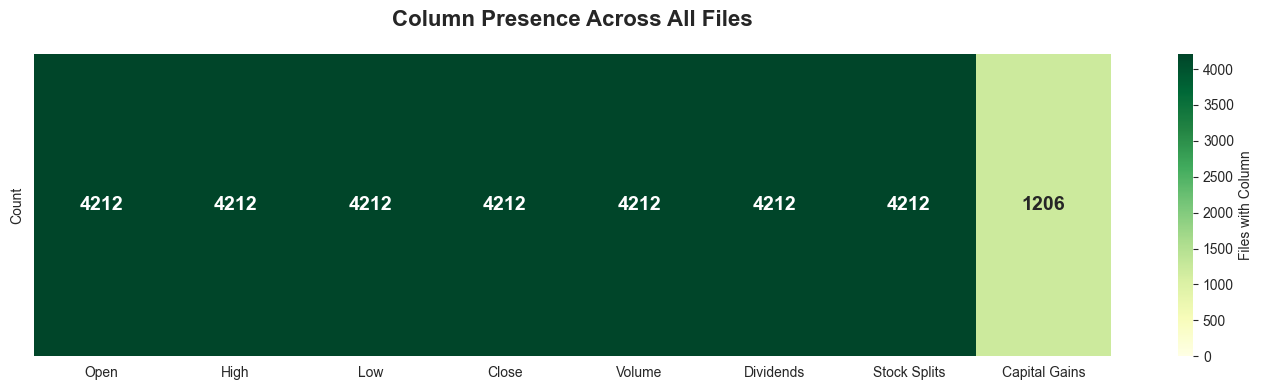

In [31]:
# 1. Column Presence Heatmap
fig, ax = plt.subplots(figsize=(14, 4))
column_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains']
presence_data = col_report[column_cols].sum().values.reshape(1, -1)
sns.heatmap(presence_data, annot=True, fmt='d', cmap='YlGn',
            cbar_kws={'label': 'Files with Column'},
            xticklabels=column_cols, yticklabels=['Count'], ax=ax,
            vmin=0, vmax=len(col_report), annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title('Column Presence Across All Files', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

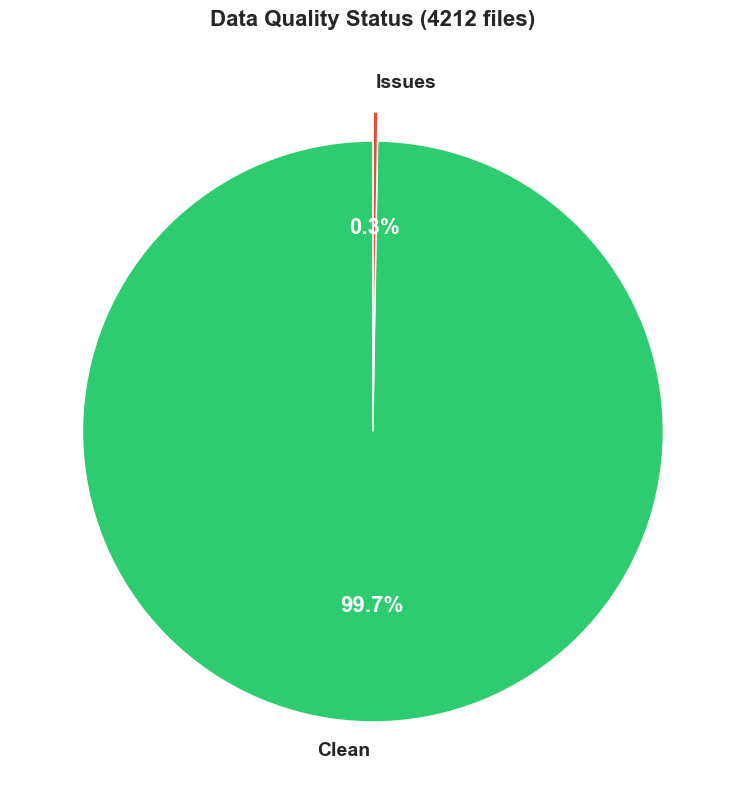

In [32]:
# 2. Data Quality Status Pie Chart
fig, ax = plt.subplots(figsize=(10, 8))
quality_counts = quality_report['Status'].value_counts()
colors = {'Clean': '#2ecc71', 'Issues': '#e74c3c', 'Load Error': '#95a5a6'}
pie_colors = [colors.get(status, '#3498db') for status in quality_counts.index]
wedges, texts, autotexts = ax.pie(quality_counts.values, labels=quality_counts.index,
                                    autopct='%1.1f%%', colors=pie_colors, startangle=90,
                                    textprops={'fontsize': 14, 'fontweight': 'bold'},
                                    explode=[0.05] * len(quality_counts))
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(16)
ax.set_title(f'Data Quality Status ({len(quality_report)} files)',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

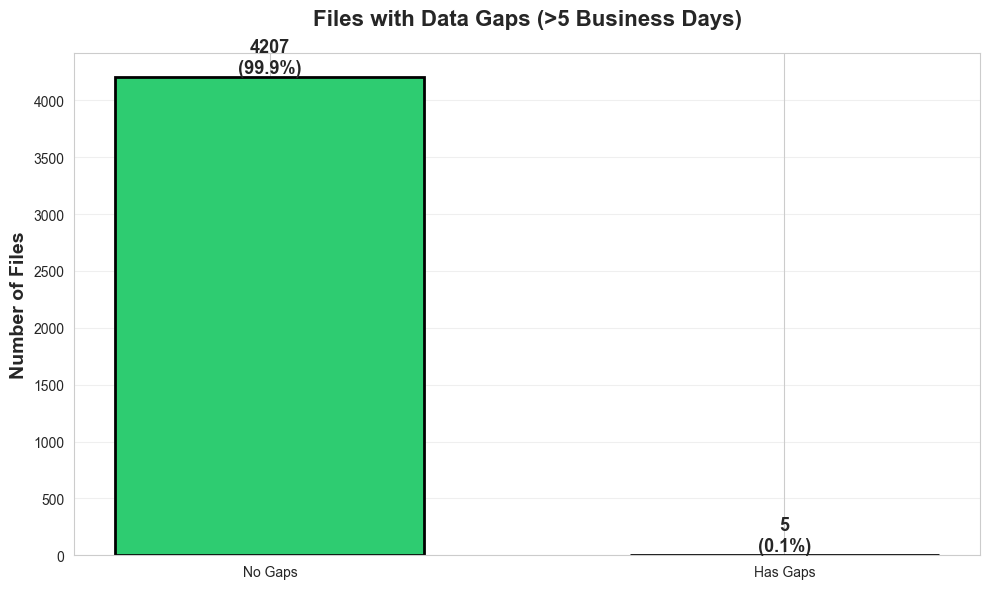

In [33]:
# 3. Gap Analysis Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
gap_summary = gap_report['Has_Gaps'].value_counts()
no_gaps = gap_summary.get(False, 0)
has_gaps = gap_summary.get(True, 0)
bars = ax.bar(['No Gaps', 'Has Gaps'], [no_gaps, has_gaps],
               color=['#2ecc71', '#f39c12'], edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Number of Files', fontsize=14, fontweight='bold')
ax.set_title('Files with Data Gaps (>5 Business Days)', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(gap_report)*100:.1f}%)',
            ha='center', va='bottom', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

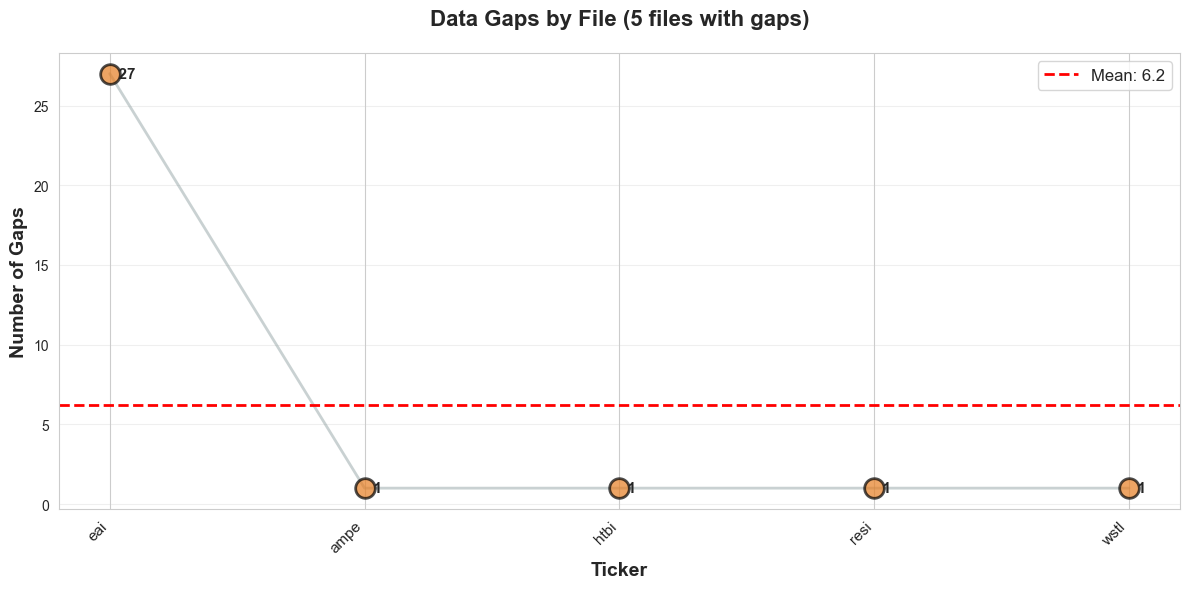

In [34]:
# SCATTER PLOT
fig, ax = plt.subplots(figsize=(12, 6))
files_with_gaps = gap_report[gap_report['Has_Gaps'] == True].copy()

if len(files_with_gaps) > 0:
    files_with_gaps = files_with_gaps.sort_values('Num_Gaps', ascending=False)
    ax.scatter(range(len(files_with_gaps)), files_with_gaps['Num_Gaps'],
               s=200, c='#e67e22', edgecolor='black', linewidth=2, alpha=0.7, zorder=3)

    ax.plot(range(len(files_with_gaps)), files_with_gaps['Num_Gaps'],
            color='#95a5a6', linewidth=2, alpha=0.5, zorder=1)

    ax.set_xticks(range(len(files_with_gaps)))
    ax.set_xticklabels(files_with_gaps['Ticker'], rotation=45, ha='right', fontsize=11)

    ax.set_ylabel('Number of Gaps', fontsize=14, fontweight='bold')
    ax.set_xlabel('Ticker', fontsize=14, fontweight='bold')
    ax.set_title(f'Data Gaps by File ({len(files_with_gaps)} files with gaps)',
                 fontsize=16, fontweight='bold', pad=20)

    for i, (idx, row) in enumerate(files_with_gaps.iterrows()):
        ax.text(i, row['Num_Gaps'], f"  {int(row['Num_Gaps'])}",
                va='center', fontsize=11, fontweight='bold')

    mean_gaps = files_with_gaps['Num_Gaps'].mean()
    ax.axhline(mean_gaps, color='red', linestyle='--', linewidth=2,
               label=f'Mean: {mean_gaps:.1f}', zorder=2)
    ax.legend(fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No gaps found!")

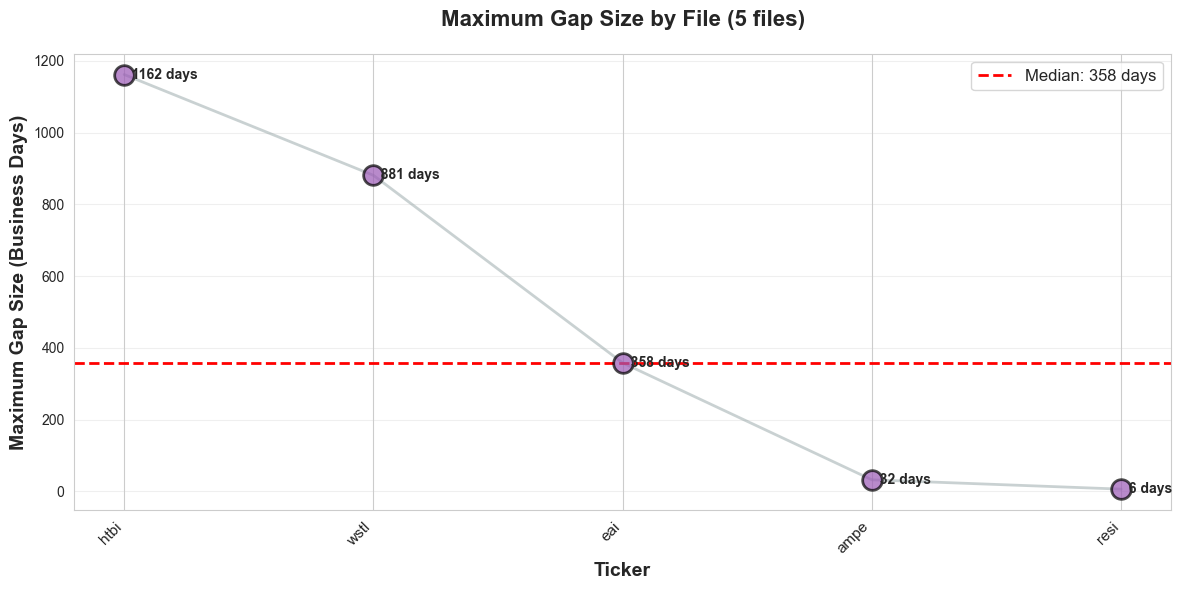

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

if len(files_with_gaps) > 0 and 'Max_Gap_Business_Days' in files_with_gaps.columns:
    files_with_gaps_sorted = files_with_gaps.sort_values('Max_Gap_Business_Days', ascending=False)

    ax.scatter(range(len(files_with_gaps_sorted)),
               files_with_gaps_sorted['Max_Gap_Business_Days'],
               s=200, c='#9b59b6', edgecolor='black', linewidth=2, alpha=0.7, zorder=3)

    ax.plot(range(len(files_with_gaps_sorted)),
            files_with_gaps_sorted['Max_Gap_Business_Days'],
            color='#95a5a6', linewidth=2, alpha=0.5, zorder=1)

    ax.set_xticks(range(len(files_with_gaps_sorted)))
    ax.set_xticklabels(files_with_gaps_sorted['Ticker'], rotation=45, ha='right', fontsize=11)

    ax.set_ylabel('Maximum Gap Size (Business Days)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Ticker', fontsize=14, fontweight='bold')
    ax.set_title(f'Maximum Gap Size by File ({len(files_with_gaps_sorted)} files)',
                 fontsize=16, fontweight='bold', pad=20)

    for i, (idx, row) in enumerate(files_with_gaps_sorted.iterrows()):
        ax.text(i, row['Max_Gap_Business_Days'], f"  {int(row['Max_Gap_Business_Days'])} days",
                va='center', fontsize=10, fontweight='bold')

    median_gap = files_with_gaps_sorted['Max_Gap_Business_Days'].median()
    ax.axhline(median_gap, color='red', linestyle='--', linewidth=2,
               label=f'Median: {median_gap:.0f} days', zorder=2)
    ax.legend(fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No gap size data available!")

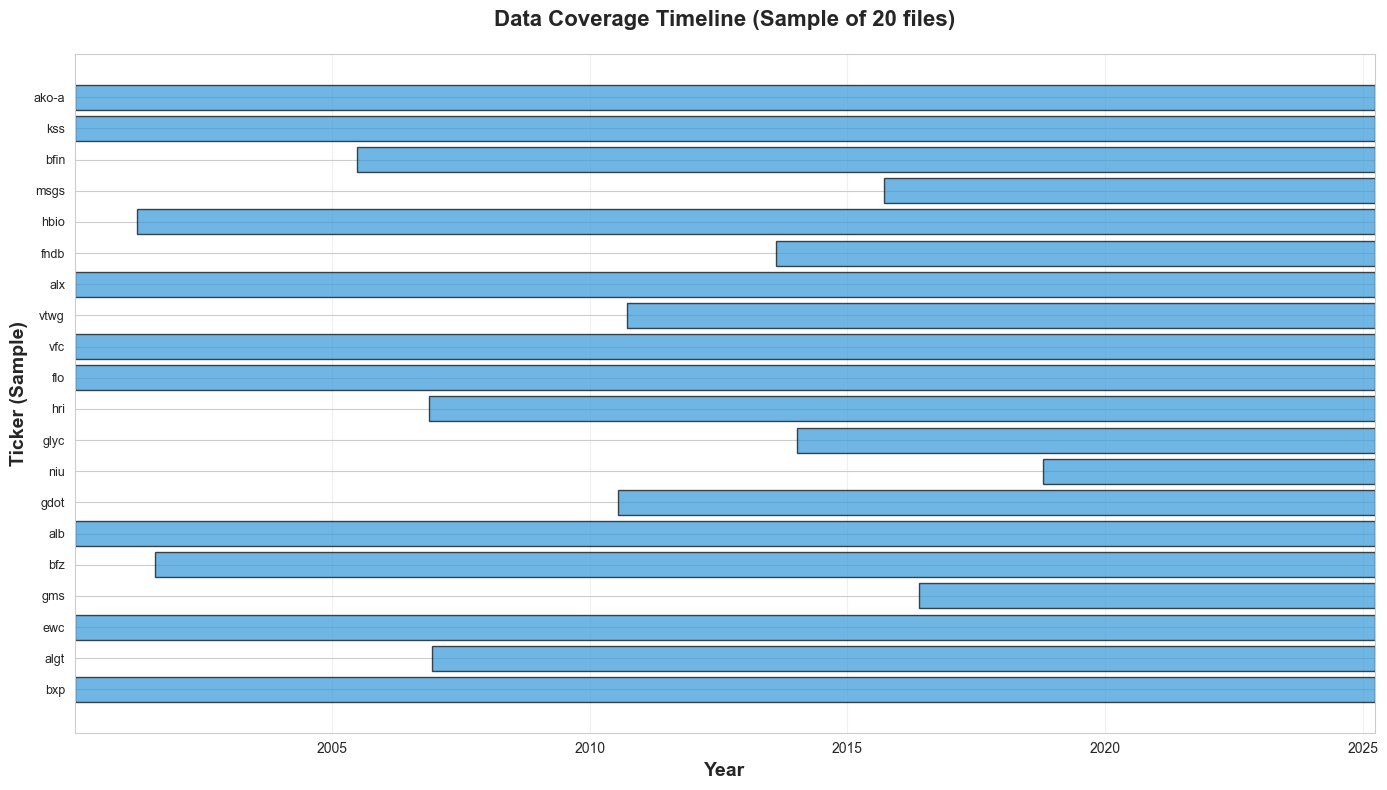

In [36]:
fig, ax = plt.subplots(figsize=(14, 8))

if 'Start_Date' in col_report.columns and 'End_Date' in col_report.columns:
    sample_size = min(20, len(col_report))
    col_sample = col_report.dropna(subset=['Start_Date', 'End_Date']).sample(n=sample_size, random_state=42)

    start_dates = pd.to_datetime(col_sample['Start_Date'], utc=True)
    end_dates = pd.to_datetime(col_sample['End_Date'], utc=True)

    for i, (idx, row) in enumerate(col_sample.iterrows()):
        start = pd.to_datetime(row['Start_Date'], utc=True)
        end = pd.to_datetime(row['End_Date'], utc=True)
        ax.barh(i, (end - start).days, left=start.timestamp()/(24*3600),
                height=0.8, color='#3498db', edgecolor='black', linewidth=1, alpha=0.7)

    from matplotlib.dates import date2num, num2date
    import matplotlib.dates as mdates

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(5))

    all_starts = pd.to_datetime(col_report['Start_Date'].dropna(), utc=True)
    all_ends = pd.to_datetime(col_report['End_Date'].dropna(), utc=True)
    ax.set_xlim(date2num(all_starts.min()), date2num(all_ends.max()))

    ax.set_yticks(range(len(col_sample)))
    ax.set_yticklabels(col_sample['Ticker'], fontsize=9)
    ax.set_xlabel('Year', fontsize=14, fontweight='bold')
    ax.set_ylabel('Ticker (Sample)', fontsize=14, fontweight='bold')
    ax.set_title(f'Data Coverage Timeline (Sample of {sample_size} files)',
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

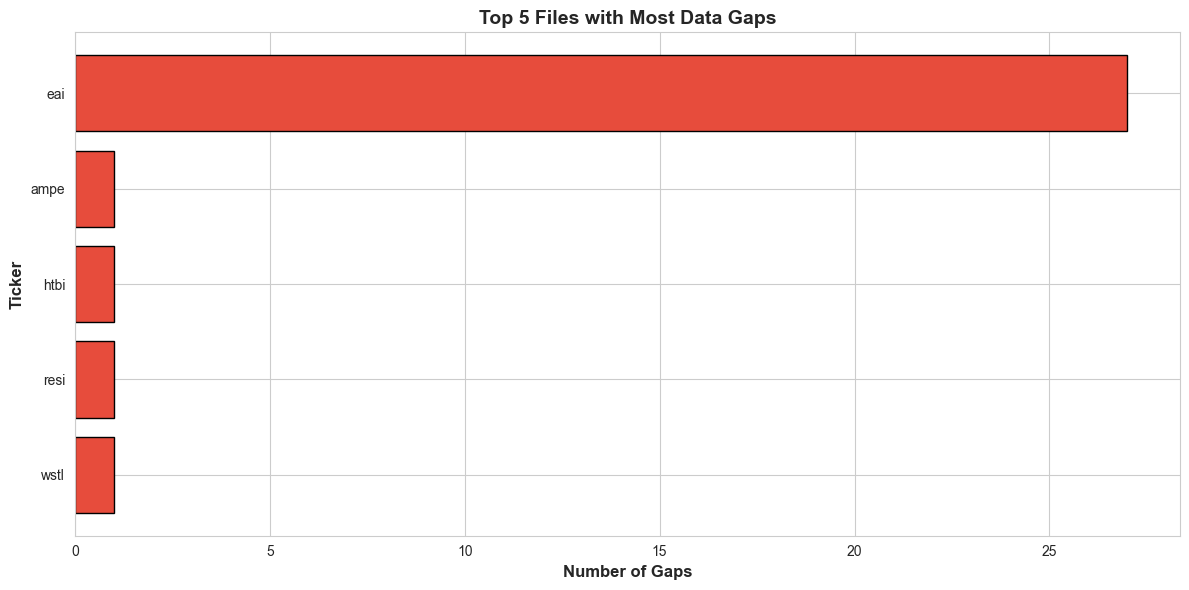

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
top_gaps = gap_report[gap_report['Has_Gaps'] == True].nlargest(5, 'Num_Gaps')
if len(top_gaps) > 0:
    ax.barh(top_gaps['Ticker'], top_gaps['Num_Gaps'], color='#e74c3c', edgecolor='black')
    ax.set_xlabel('Number of Gaps', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ticker', fontsize=12, fontweight='bold')
    ax.set_title('Top 5 Files with Most Data Gaps', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No files with gaps to display")

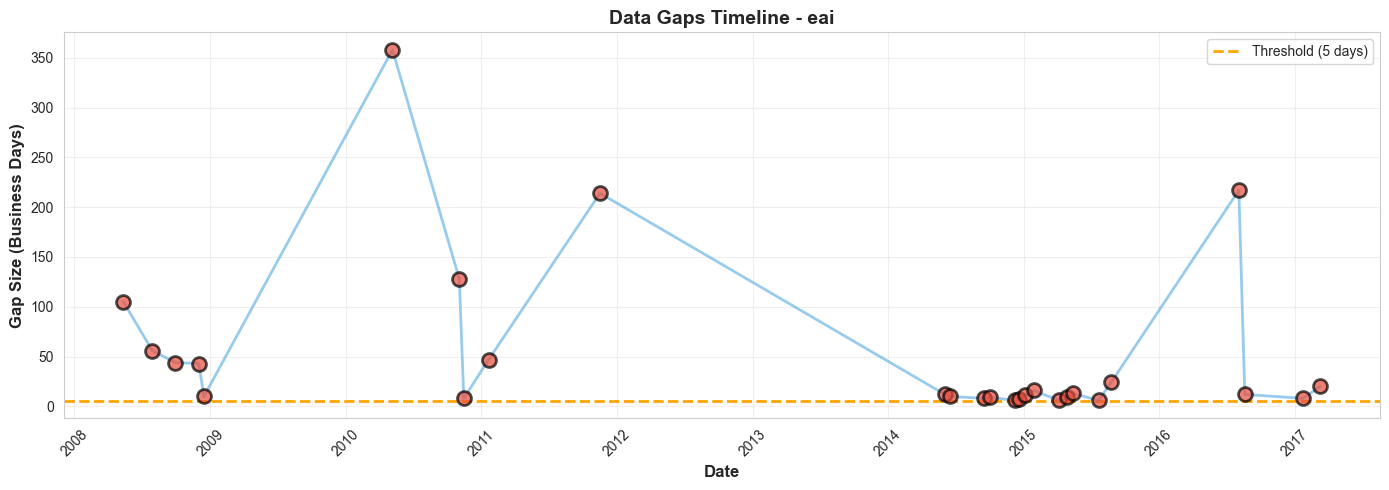

In [38]:
def plot_ticker_gaps(ticker_name):
    """Plot gaps for a specific ticker"""
    gap_data = gap_report[gap_report['Ticker'] == ticker_name]

    if len(gap_data) == 0:
        print(f"Ticker {ticker_name} not found")
        return

    if not gap_data['Has_Gaps'].iloc[0]:
        print(f"{ticker_name} has no gaps!")
        return

    gaps = pd.DataFrame(gap_data['Gap_Details'].iloc[0])

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.scatter(gaps['Date'], gaps['Business_Days_Gap'], s=100, color='#e74c3c',
               edgecolor='black', linewidth=2, alpha=0.7, zorder=3)
    ax.plot(gaps['Date'], gaps['Business_Days_Gap'], color='#3498db',
            linewidth=2, alpha=0.5, zorder=2)
    ax.axhline(y=5, color='orange', linestyle='--', linewidth=2,
               label='Threshold (5 days)', zorder=1)

    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Gap Size (Business Days)', fontsize=12, fontweight='bold')
    ax.set_title(f'Data Gaps Timeline - {ticker_name}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_ticker_gaps('eai')

In [39]:
col_report.head(10)

,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Start_Date,End_Date,Total_Rows
0,aa,True,True,True,True,True,True,True,False,2000-01-03 00:00:00-05:00,2025-03-28 00:00:00-04:00,6348
1,aaau,True,True,True,True,True,True,True,True,2018-08-15 00:00:00-04:00,2025-03-28 00:00:00-04:00,1664
2,aacg,True,True,True,True,True,True,True,False,2008-01-29 00:00:00-05:00,2025-03-28 00:00:00-04:00,4320
3,aadr,True,True,True,True,True,True,True,True,2010-07-21 00:00:00-04:00,2025-03-28 00:00:00-04:00,3696
4,aal,True,True,True,True,True,True,True,False,2005-09-27 00:00:00-04:00,2025-03-28 00:00:00-04:00,4907
5,aame,True,True,True,True,True,True,True,False,2000-01-03 00:00:00-05:00,2025-03-28 00:00:00-04:00,6348
6,aaoi,True,True,True,True,True,True,True,False,2013-09-26 00:00:00-04:00,2025-03-28 00:00:00-04:00,2894
7,aaon,True,True,True,True,True,True,True,False,2000-01-03 00:00:00-05:00,2025-03-28 00:00:00-04:00,6348
8,aap,True,True,True,True,True,True,True,False,2001-11-29 00:00:00-05:00,2025-03-28 00:00:00-04:00,5870
9,aapl,True,True,True,True,True,True,True,False,2000-01-03 00:00:00-05:00,2025-03-28 00:00:00-04:00,6348


In [40]:
gap_tickers = ['ampe', 'eai', 'htbi', 'resi', 'wstl']
gap_stock_dates = col_report[col_report['Ticker'].isin(gap_tickers)][['Ticker', 'Start_Date', 'End_Date']]
print(gap_stock_dates)

     Ticker                 Start_Date                   End_Date
204    ampe  2008-07-31 00:00:00-04:00  2025-03-28 00:00:00-04:00
1210    eai  2007-12-17 00:00:00-05:00  2017-03-13 00:00:00-04:00
2069   htbi  2003-12-02 00:00:00-05:00  2025-03-28 00:00:00-04:00
3265   resi  2022-01-04 00:00:00-05:00  2023-12-13 00:00:00-05:00
4077   wstl  2000-01-03 00:00:00-05:00  2025-03-28 00:00:00-04:00
